In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"febrianandinugroho","key":"25917f6e04c20b5d92a4e426d9a6fc67"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arashnic/time-series-forecasting-with-yahoo-stock-price


  0% 0.00/33.1k [00:00<?, ?B/s]
100% 33.1k/33.1k [00:00<00:00, 76.3MB/s]


In [ ]:
!unzip time-series-forecasting-with-yahoo-stock-price.zip

Archive:  time-series-forecasting-with-yahoo-stock-price.zip
  inflating: yahoo_stock.csv         


In [ ]:
data = pd.read_csv('yahoo_stock.csv', na_values='ND')

In [ ]:
data.shape

(1825, 7)

In [ ]:
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [ ]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [ ]:
data_prices = data.drop(['Date', 'Volume', 'Adj Close'], axis=1)

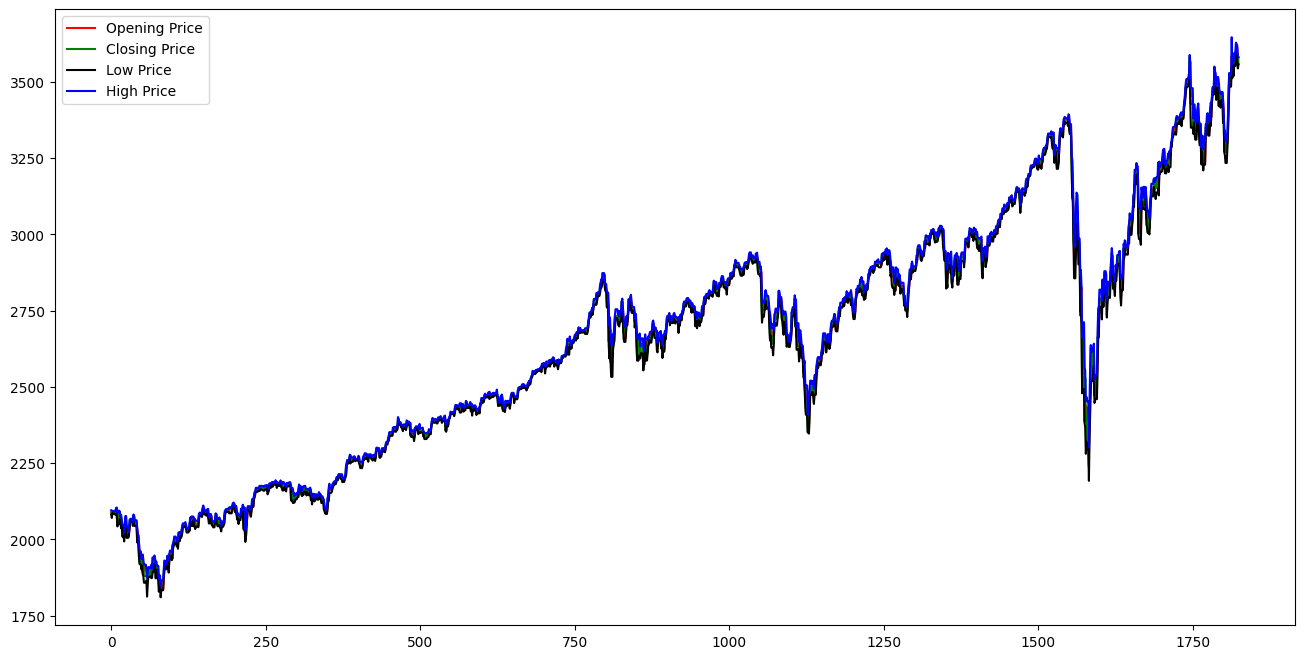

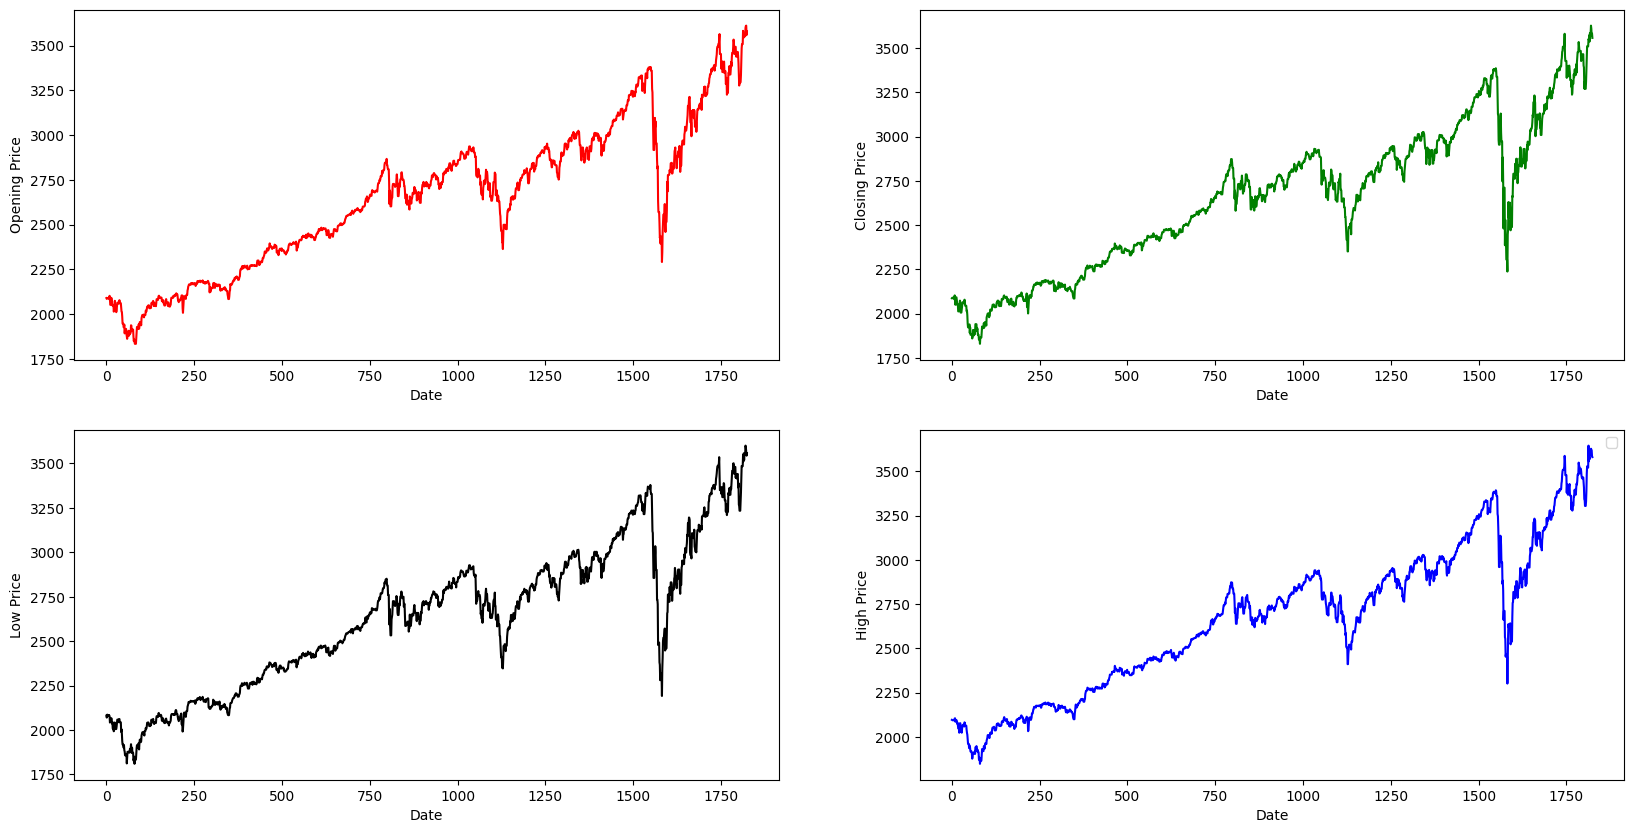

In [ ]:
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(data_prices['Open'], color='red', label = 'Opening Price')
plt.plot(data_prices['Close'], color='green', label = 'Closing Price')
plt.plot(data_prices['Low'], color='black', label = 'Low Price')
plt.plot(data_prices['High'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(data_prices['Open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(data_prices['Close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')

ax3 = plt.subplot(2, 2, 3)
plt.plot(data_prices['Low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(data_prices['High'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')

plt.legend(loc='best')

In [ ]:
data_prices = data_prices.drop(['Close', 'Low', 'High'], axis=1)

In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
data_prices_scaled = sc.fit_transform(data_prices)

In [ ]:
data_prices_scaled.shape

(1825, 1)

In [ ]:
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])

    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))

    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]

    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_prices_scaled, n_future=1, n_past=25, train_test_split_percentage=0.8,validation_split_percentage = 0)

In [ ]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(1440, 25, 1)
(360, 25, 1)
(1440, 1)
(360, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 25, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


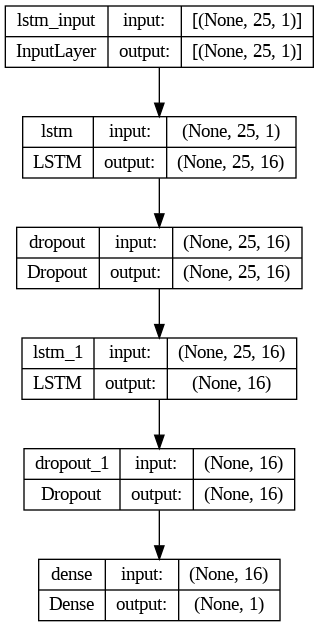

In [ ]:
from tensorflow.keras.utils import plot_model

regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()
plot_model(regressor, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
18/18 [==============================] - 3s 49ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 2/40
18/18 [==============================] - 0s 12ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1330
Epoch 3/40
18/18 [==============================] - 0s 11ms/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 4/40
18/18 [==============================] - 0s 12ms/step - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 9.0969e-04 - val_root_mean_squared_error: 0.0302
Epoch 5/40
18/18 [==============================] - 0s 12ms/step - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 9.0200e-04 - val_root_mean_squared_error: 0.0300
Epoch 6/40
18/18 [==============================] - 0s 12ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0012 - va

In [ ]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

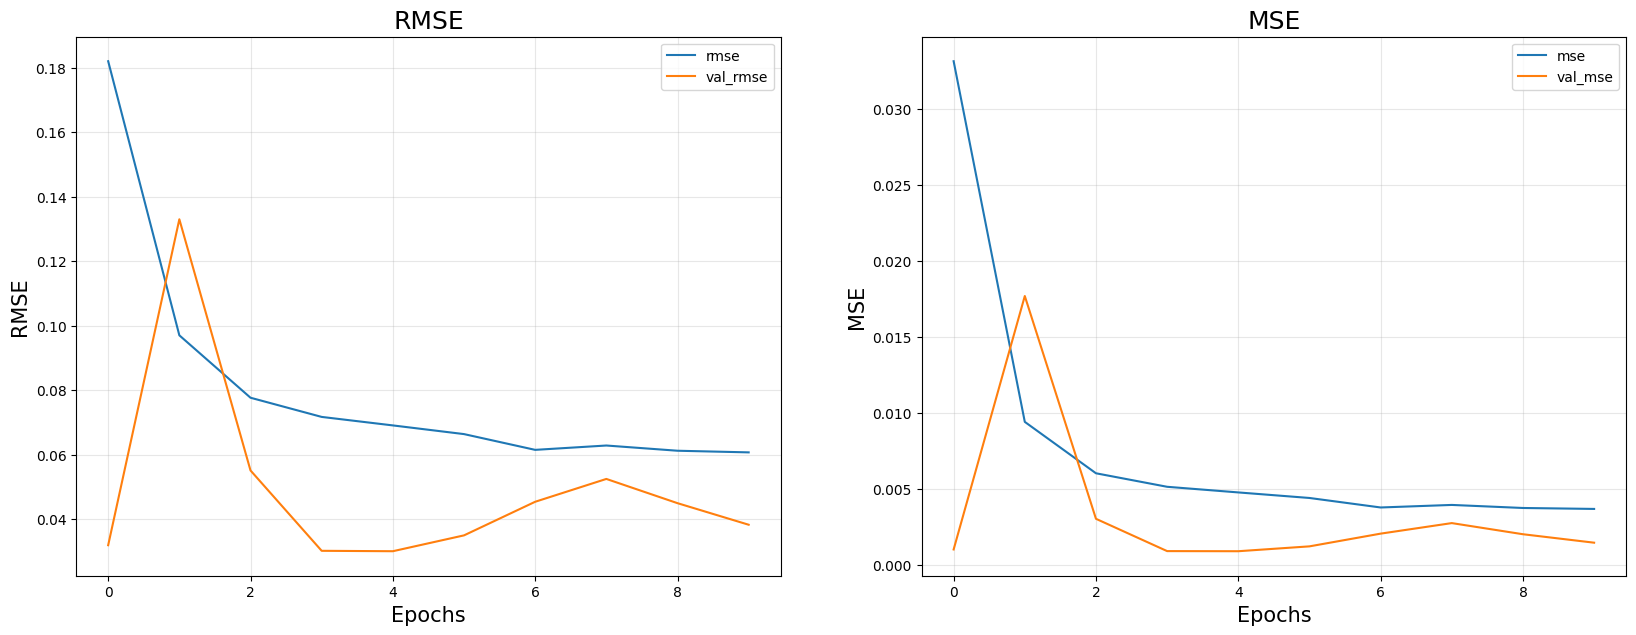

In [ ]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="mse")
plt.plot(history.epoch, history.history['val_loss'], label="val_mse")

plt.title("MSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [ ]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

12/12 [==============================] - 0s 6ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835
test loss, test acc: [0.007  0.0835]


12/12 [==============================] - 1s 3ms/step


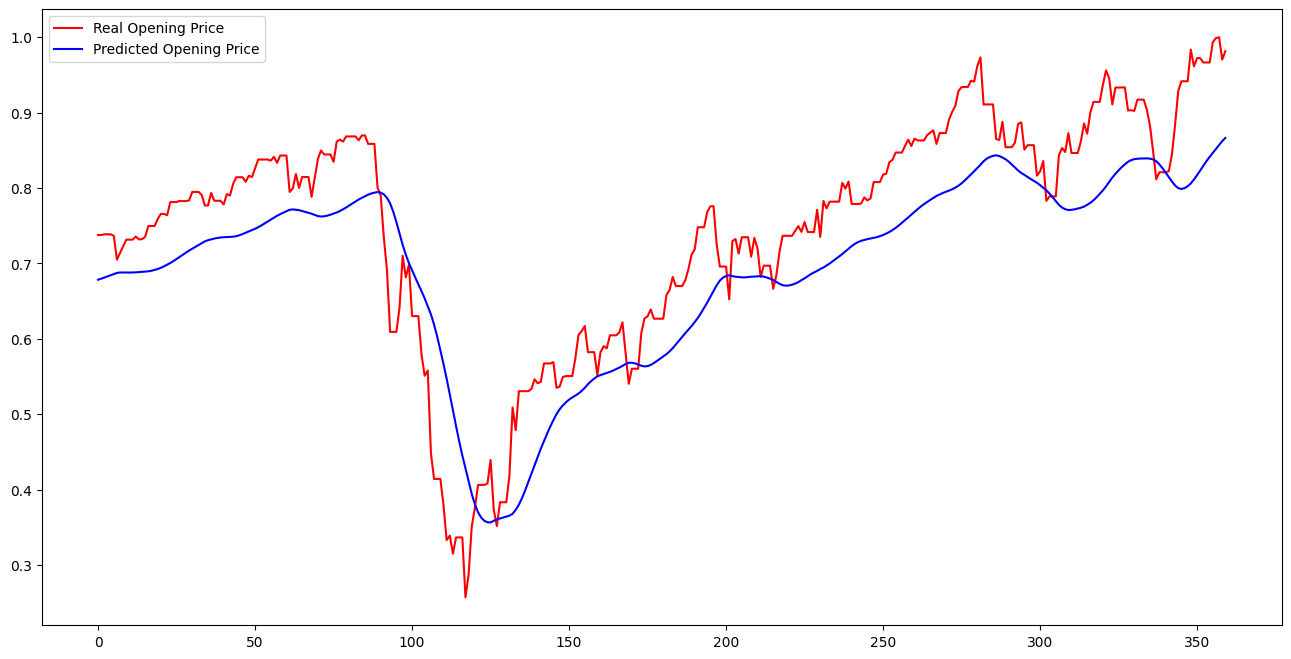

In [ ]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Opening Price')
plt.plot(y_pred, color='blue', label = 'Predicted Opening Price')
plt.legend(loc='best')